In [2]:
#load modules
from matplotlib import pyplot as plt
import numpy as np
from spectral1d import solve_nonlinear_problem # needed module
from overscreening_breakdown import overscreening_breakdown #needed module
%matplotlib inline

In [ ]:
#init the problem
problem = overscreening_breakdown()

In [ ]:
#set up the solver
N = 100
domain = [0,np.inf]
tolerance = 1.0e-10
use_method = "newton"
L = 6
solver = solve_nonlinear_problem(N=N, domain=[0,np.inf], tolerance=tolerance, use_method=use_method)
solver.set_mapping_parameter(L)

In [ ]:
#set up problem.
#If a parameter is not given, then a default value is used instead. See the source file of "overscreening_breakdown" for more details

sigma = 20.0
mu = 0.36
gamma = 1
delta = 10.0
u0 = 0.1
u0xxx = 0

def some_func(x):
    return u0*np.exp(-x**4)

problem.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func)

In [ ]:
#pass the problem to the solver
solver.set_problem(problem)

In [ ]:
# solve the problem
c = solver.solve_problem()

In [ ]:
#optionally save and load a solution for further use
#solution is stored in expension coefficients
solver.save_solution("solution.pickle", c)
c1 = solver.load_data("solution.pickle")
print("checking difference in saved data: ", np.linalg.norm(c-c1))

In [ ]:
#see the solution
t = np.arange(0, np.pi, 0.01)
sol = solver.obtain_solution_in_basis(c, t)
plt.title("solution on the mapped segment [0,$\pi$]")
plt.plot(t, sol)
plt.show()
x = np.arange(0.0, 40.0, 0.1)
sol = solver.obtain_solution_in_domain(c, x)
plt.title("solution on the part of the $\mathbb{R}^+$")
plt.plot(x, sol)
plt.show()

Next we demonstrate the applicaiton of the size globalization for a very stiff problem using globalization in the size of the problem thanx to the natural behaviour of the spectral methods.

In [ ]:
sigma = 10.0
mu = 1
gamma = 1/2
delta = 50.0
u0 = 200.0
u0xxx = 0

def some_func(x):
    return np.exp(-x**2) #initial guess should be u0*np.exp(-x**2). This breaks the problem convergence

problem.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func)

In [ ]:
# normal size problem fails to converge due to very stiff nonlinearity (artificially made)
N = 100
solver = solve_nonlinear_problem(N=N, domain=[0,np.inf], tolerance=tolerance, use_method=use_method, total_iterations = 20, use_globalization = False)
solver.set_mapping_parameter(L)
solver.set_problem(problem)
c = solver.solve_problem()

In [ ]:
# we perfrom a set of iterations to update a better initial guess from the smaller problem size
N_base = 20
N = N_base
c1 = None
for it in range(2,11):
    print("running on N = ", N)
    solver = solve_nonlinear_problem(N=N, domain=[0,np.inf], tolerance=tolerance, use_method=use_method, total_iterations = 20, use_globalization = False)
    solver.set_mapping_parameter(L)
    solver.set_problem(problem)
    c = solver.solve_problem(c1)
    if solver.is_converged():
        c1 = np.copy(c)
        N = N_base*it
    else:
        N = N - 1

In [ ]:
#and check 2 final consecutive solutions 
t = np.arange(0, np.pi, 0.01)
sol1 = solver.obtain_solution_in_basis(c1, t)
sol = solver.obtain_solution_in_basis(c, t)
plt.title("solution on the mapped segment [0,$\pi$]")
plt.plot(t, sol1, '.')
plt.plot(t, sol)
plt.show()

Next we demonstrate the applicaiton of the homotopy* globalization for the same stiff problem.

*https://en.wikipedia.org/wiki/Homotopy

In [ ]:
solver = solve_nonlinear_problem(N=100, domain=[0,np.inf], tolerance=tolerance, use_method="newton", total_iterations = 20, use_globalization = True)
solver.set_mapping_parameter(L)
solver.set_problem(problem)

In [ ]:
c2 = solver.solve_problem()

In [ ]:
#and demonstrate the converged solution compared with the previous one
t = np.arange(0, np.pi, 0.01)
sol = solver.obtain_solution_in_basis(c1, t)
sol2 = solver.obtain_solution_in_basis(c2, t)
plt.title("compare two solutions on the mapped segment [0,$\pi$]")
plt.plot(t, sol2,'.')
plt.plot(t, sol)
plt.show()
plt.title("error between two solutions (obtained from size and homotopy globalizations) on the mapped segment [0, $\pi$]")
plt.plot(t, sol-sol2)
plt.show()

**Here we demonstrate how to find a stable value of the mapping parameter L for the given problem.**

One should choose the smallest possible value of L at which the solutions are stable w.r.t. the discretization

In [ ]:
sigma = 10.0
mu = 1
gamma = 1/2
delta = 10.0
u0 = 1.0
u0xxx = 0

def some_func(x):
    return u0*np.exp(-x**2) #solution initial guess

problem.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func)

In [ ]:
Nall = [30,70,80,100]
Lall = [1,2,3,4,5]
t = np.arange(0, np.pi, 0.01)
x = np.arange(0, 100, 0.1)
for L in Lall:
    c_dict = {}
    c1 = None
    for N in Nall:
        solver = solve_nonlinear_problem(N=N, domain=[0,np.inf], tolerance=tolerance, use_method="newton", total_iterations = 20, use_globalization = False)
        solver.set_mapping_parameter(L)
        solver.set_problem(problem)
        c = solver.solve_problem(c1)
        c_dict[N] = c
        c1 = np.copy(c)
    for N in Nall:
        c_l = c_dict[N]
        sol = solver.obtain_solution_in_basis(c_l, t)
        plt.plot(t, sol, label=N)
        
    plt.legend()
    plt.title("segement, L = " + str(L))
    plt.show()
    
    for N in Nall:
        c_l = c_dict[N]
        sol = solver.obtain_solution_in_domain(c_l, x)
        plt.plot(x, sol, label=N)
        
    plt.legend()
    plt.title("$\mathbb{R}^+$, L = " + str(L))
    plt.show()    
    
print("For this problem it is recomended to use L=4.")

newton: relative target tolerance =  1.0099504938362077e-11
newton: iteration  1 , residual norm  0.005097207502964341 , wight =  1.0
newton: iteration  2 , residual norm  2.023072834355502e-06 , wight =  1.0
newton: iteration  3 , residual norm  6.245184057990477e-13 , wight =  1.0
converged with norm =  6.245184057990477e-13


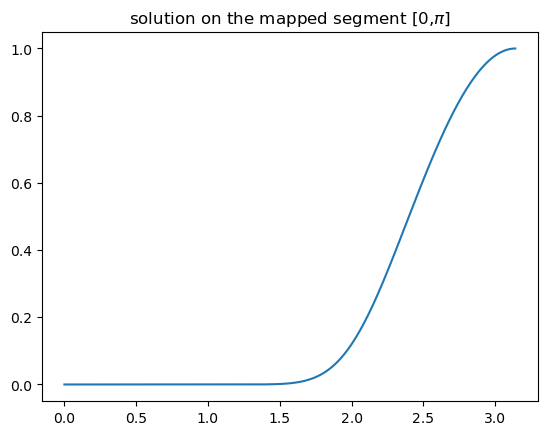

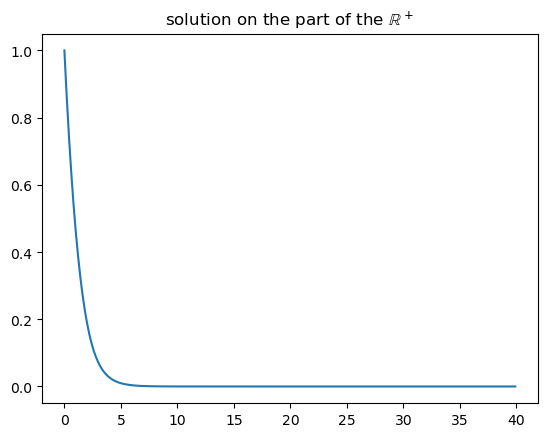

In [63]:
#Example on hw to solve the Poisson problem.
# u_xx = f(x,u)

sigma = 1.0
mu = 1
gamma = 1
delta = 0.0  # remove the 4-th order derivative
u0 = 1.0     
u0xxx = None # remove the third derivative boundary condition


def some_func(x):
    return u0*np.exp(-x**4)
problem = overscreening_breakdown()
problem.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func)
#pass the problem to the solver
solver.set_problem(problem)
# solve the problem
c = solver.solve_problem()

#see the solution
t = np.arange(0, np.pi, 0.01)
sol = solver.obtain_solution_in_basis(c, t)
plt.title("solution on the mapped segment [0,$\pi$]")
plt.plot(t, sol)
plt.show()
x = np.arange(0.0, 40.0, 0.1)
sol = solver.obtain_solution_in_domain(c, x)
plt.title("solution on the part of the $\mathbb{R}^+$")
plt.plot(x, sol)
plt.show()